In [4]:
import numpy as np
import torch
import nibabel as nib

from utils.SAMMed3D_segment_anything.build_sam3D import build_sam3D_vit_b_ori
from classes.SAMMed3DClass import SAMMed3DInferer, SAMMed3DWrapper

import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

def load_sammed3d(checkpoint_path, device = 'cuda'):
    device = 'cuda'
    checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d.pth'

    sam_model_tune = build_sam3D_vit_b_ori(checkpoint=None)
    if checkpoint_path is not None:
        model_dict = torch.load(checkpoint_path, map_location=device)
        state_dict = model_dict['model_state_dict']
        sam_model_tune.load_state_dict(state_dict)

    return (sam_model_tune)

def read_im_gt_ras(img_path, gt_path, organ_label = None):
    img, gt = nib.load(img_path), nib.load(gt_path)
    img_ras, gt_ras = img, gt  # Initialize variables to hold potentially reoriented images

    # Check if gt, image are already in RAS+ 
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        img_ras = nib.as_closest_canonical(img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        gt_ras = nib.as_closest_canonical(gt)

    img_data = img_ras.get_fdata().astype(np.float32)
    gt_data = gt_ras.get_fdata().astype(int)

    # Ensure organ is binary
    if organ_label is None:
        flat_data = gt_data.ravel()
        if not np.all( (flat_data == 0) | (flat_data == 1)):
            raise ValueError('Ground truth is not binary and no foreground label to subset to is specified')
        
    else:
        gt_data = (gt_data == organ_label).astype(int)
    
    return(img_data, gt_data)

# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_med3d.pth'
sammed3d_model = load_sammed3d(checkpoint_path, device)
SAMMed3D_wrapper = SAMMed3DWrapper(sammed3d_model, device)
inferer = SAMMed3DInferer(SAMMed3D_wrapper)

img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
img, gt = read_im_gt(img_path, gt_path, RAS = True)

# img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
# img, gt = read_im_gt(img_path, gt_path, 2, RAS = True)


In [7]:
# Experiment: n randomly selected fg points
n = 5
seed = 11121

pts_prompt = prUt.get_pos_clicks3D(gt, n, seed)
segmentation = inferer.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

0.7288015494354954

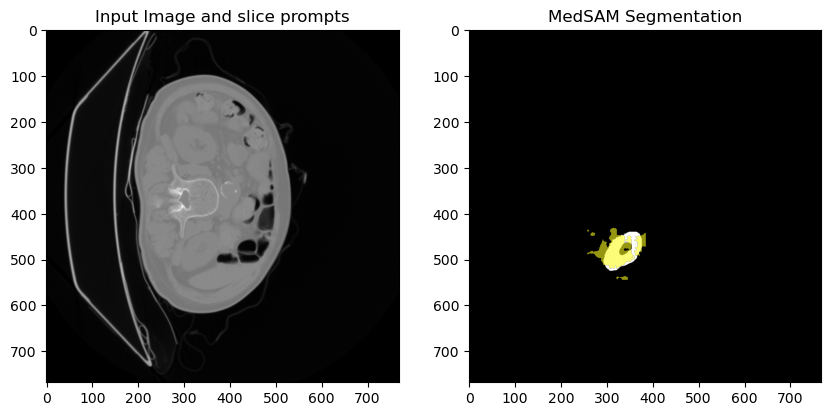

0.6556412337662337

In [3]:
slice_idx = 55
anUt.show_seg(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)